In [1]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from io import StringIO
import pandas as pd

from util import *
from plotting_helpers import *
from generation import *

# === CONFIG ===
current_dir = os.path.dirname(os.getcwd())
FILE_PATH = os.path.join(current_dir, "data", "IBM", "HI-Small_Patterns.txt")


current_dir = os.path.dirname(os.getcwd())
CSV_PATH = os.path.join(current_dir, "data", "IBM", "Hi-Small_Trans.csv")


pattern_dict = create_pattern_dict(FILE_PATH)

bipartite_data = filter_dict(pattern_dict, "BIPARTITE" )  # Example usage function

df_data = pd.DataFrame(bipartite_data, columns=columns)
df_data['src'] = df_data['From Bank'] + "_" + df_data['From Account']
df_data['dst'] = df_data['To Bank'] + "_" + df_data['To Account']



Looking for file at:
c:\Users\lucsc\Thesis\grad\grad\data\IBM\HI-Small_Patterns.txt

File not found!


In [2]:
df_data.sort_values(by=['src'], inplace=True)
len(df_data['dst'].unique())

# 1. detect duplicates inside each column
dup_col1 = df_data['src'].duplicated(keep=False)
dup_col2 = df_data['dst'].duplicated(keep=False)

# 2. detect values that appear in BOTH columns
values_in_both = df_data['src'].isin(df_data['dst']) | df_data['dst'].isin(df_data['src'])

# 3. final mask: keep rows where ANY of the above is true
mask = dup_col1 | dup_col2 | values_in_both

df_filtered = df_data[mask]

plot_laundering_pattern("duplicate bipartite filtered", df_filtered.values.tolist())

✅ Saved plot for 'duplicate bipartite filtered' to: c:\Users\lucsc\Thesis\grad\grad\dataprep\pattern_plots\duplicate_bipartite_filtered.png


In [3]:
plot_laundering_pattern("STACKfiltered", df_filtered.values.tolist())

✅ Saved plot for 'STACKfiltered' to: c:\Users\lucsc\Thesis\grad\grad\dataprep\pattern_plots\STACKfiltered.png


In [4]:
# Load your data first

df = pd.read_csv(CSV_PATH, dtype=str)
df["Is Laundering"] = pd.to_numeric(df["Is Laundering"], errors="coerce").fillna(2).astype(int)
df = df[df['Is Laundering'] ==1]

# full_data["Amount Paid"] = full_data["Amount Paid"].astype(float)
# full_data["Amount Received"] = full_data["Amount Received"].astype(float)

df["From_Node"] = df["From Bank"].astype(str) + "_" + df["Account"].astype(str)
df["To_Node"] = df["To Bank"].astype(str) + "_" + df["Account.1"].astype(str)

START_ACCOUNT = "0222_812D127D0"


connected_df, connected_nodes = gather_suspicious_network(df, start_node=START_ACCOUNT)

print(f"Found {len(connected_nodes)} suspicious connected nodes")
print(f"Found {len(connected_df)} suspicious related transactions")

# Visualize the suspicious network
visualize_suspicious_network(connected_df, start_node=START_ACCOUNT)


Found 2 suspicious connected nodes
Found 10 suspicious related transactions


c:\Users\lucsc\Thesis\grad\grad\dataprep\plotting_helpers.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


📈 Saved visualization to suspicious_plots\suspicious_network_0222_812D127D0.png


In [5]:
all_nodes = set(df["From_Node"]).union(set(df["To_Node"]))

def process_all_suspicious_networks(df):
    """
    Iteratively discovers suspicious networks without reusing nodes.
    """

    all_nodes = set(df["From_Node"]).union(set(df["To_Node"]))
    unvisited_nodes = set(all_nodes)
    global_seen_nodes = set()

    networks = []  # store results

    while unvisited_nodes:
        start_node = unvisited_nodes.pop()

        # Skip if already covered
        if start_node in global_seen_nodes:
            continue

        connected_df, connected_nodes = gather_suspicious_network(
            df,
            start_node=start_node
        )

        # If nothing suspicious found, just mark visited
        if not connected_nodes:
            global_seen_nodes.add(start_node)
            continue

        # Store result
        networks.append({
            "start_node": start_node,
            "nodes": connected_nodes,
            "transactions": connected_df
        })

        # Mark all discovered nodes as globally seen
        global_seen_nodes.update(connected_nodes)

        # Remove them from future start-node consideration
        unvisited_nodes.difference_update(connected_nodes)

        print(
            f"Network from {start_node}: "
            f"{len(connected_nodes)} nodes, "
            f"{len(connected_df)} transactions"
        )

    return networks


In [6]:
df = df[df['Is Laundering'] ==1]

networks = process_all_suspicious_networks(df)

print(f"\nDiscovered {len(networks)} unique suspicious networks\n")

# for i, net in enumerate(networks, 1):
#     print(
#         f"[{i}] Start node: {net['start_node']} | "
#         f"Nodes: {len(net['nodes'])} | "
#         f"Transactions: {len(net['transactions'])}"
#     )
#     if len(net['nodes']) > 3:
#         visualize_suspicious_network(
#             net["transactions"],
#             start_node=net["start_node"]
#         )


Network from 003420_80AEBD9D0: 17 nodes, 16 transactions
Network from 024840_809BD82B0: 2 nodes, 1 transactions
Network from 029279_803628620: 2 nodes, 1 transactions
Network from 022828_8011150C0: 3 nodes, 3 transactions
Network from 02843_80B7E71D0: 3 nodes, 2 transactions
Network from 010_8003E7740: 14 nodes, 13 transactions
Network from 0214_809291B70: 2 nodes, 1 transactions
Network from 0031653_80F242AA0: 2 nodes, 1 transactions
Network from 003698_80333C8E0: 3 nodes, 2 transactions
Network from 0021568_808130D40: 2 nodes, 1 transactions
Network from 0043049_80FE11FA0: 3 nodes, 2 transactions
Network from 004503_80C33DAC0: 23 nodes, 22 transactions
Network from 0013029_804CA7210: 3 nodes, 2 transactions
Network from 002385_80F12D810: 2 nodes, 1 transactions
Network from 0230257_80B633E10: 2 nodes, 1 transactions
Network from 0120691_811060DC0: 190 nodes, 191 transactions
Network from 01674_801284F30: 2 nodes, 1 transactions
Network from 020_8030A5760: 5 nodes, 4 transactions
Netw

In [7]:
networks[0]

{'start_node': '003420_80AEBD9D0',
 'nodes': {'0015_80AD14210',
  '0018405_806FD7DE0',
  '003420_80AEBD9D0',
  '003514_80212D6B0',
  '0043460_8107E4020',
  '005836_802E7F950',
  '0122352_81071EAA0',
  '0124368_80E427DE0',
  '013862_801F99F20',
  '014549_801D08580',
  '01601_811F005C0',
  '016109_808252DC0',
  '017321_80A090510',
  '0213580_8123CC980',
  '0214749_805DB7F20',
  '0219449_80A37E600',
  '027637_8043C7360'},
 'transactions':                 Timestamp From Bank    Account  To Bank  Account.1  \
 4563194  2022/09/09 12:00   0214749  805DB7F20  0124368  80E427DE0   
 4563196  2022/09/09 14:43   0214749  805DB7F20   013862  801F99F20   
 4563198  2022/09/09 17:48   0214749  805DB7F20   003420  80AEBD9D0   
 4563200  2022/09/09 18:37   0214749  805DB7F20  0043460  8107E4020   
 4563202  2022/09/09 20:16   0214749  805DB7F20  0122352  81071EAA0   
 4563204  2022/09/10 09:47   0214749  805DB7F20   014549  801D08580   
 4563206  2022/09/11 05:55   0214749  805DB7F20  0018405  806FD7

In [8]:
net = networks[0]
print(
    f"[1] Start node: {net['start_node']} | "
    f"Nodes: {len(net['nodes'])} | "
    f"Transactions: {len(net['transactions'])}"
)
if len(net['nodes']) > 3:
    visualize_suspicious_network(
        net["transactions"],
        start_node=net["start_node"],
        save_folder="tests"
    )

[1] Start node: 003420_80AEBD9D0 | Nodes: 17 | Transactions: 16


c:\Users\lucsc\Thesis\grad\grad\dataprep\plotting_helpers.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


📈 Saved visualization to tests\suspicious_network_003420_80AEBD9D0.png


In [ ]:
G, pos = generate_pattern(pattern_type="Bipartite", n_left=2, n_right=3, laudering=1
                 )

plot_generated_data(G, pos)

TypeError: plot_generated_data() missing 1 required positional argument: 'pattern_type'

: 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transaction_network(
    df,
    start_node,
    max_depth=5,
    collapse_threshold=10
):
    """
    Visualize transaction network starting from a given node,
    coloring nodes based on Is Laundering label.
    """

    G = nx.DiGraph()
    visited = set()
    node_laundering_flag = {}

    def is_node_laundering(node):
        """Return True if node appears in any laundering transaction"""
        return not df[
            ((df["From_Node"] == node) | (df["To_Node"] == node)) &
            (df["Is Laundering"] == 1)
        ].empty

    def recurse(node, depth):
        if depth > max_depth or node in visited:
            return

        visited.add(node)

        # Store laundering flag
        node_laundering_flag[node] = is_node_laundering(node)

        outgoing = df[df["From_Node"] == node]["To_Node"].tolist()
        incoming = df[df["To_Node"] == node]["From_Node"].tolist()
        neighbors = set(outgoing + incoming)

        # Collapse highly connected nodes
        if len(neighbors) > collapse_threshold:
            summary_node = f"{node}\n(+{len(neighbors)} connections)"
            G.add_node(summary_node)
            node_laundering_flag[summary_node] = None  # summary node
            G.add_edge(node, summary_node)
            return

        for nbr in neighbors:
            node_laundering_flag[nbr] = is_node_laundering(nbr)

            if not df[
                (df["From_Node"] == node) &
                (df["To_Node"] == nbr)
            ].empty:
                G.add_edge(node, nbr)

            if not df[
                (df["From_Node"] == nbr) &
                (df["To_Node"] == node)
            ].empty:
                G.add_edge(nbr, node)

            recurse(nbr, depth + 1)

    recurse(start_node, depth=0)

    # ---- Node coloring ----
    node_colors = []
    for node in G.nodes():
        flag = node_laundering_flag.get(node)
        if flag is True:
            node_colors.append("red")      # laundering
        elif flag is False:
            node_colors.append("lightblue") # clean
        else:
            node_colors.append("gray")     # collapsed node

    # ---- Visualization ----
    plt.figure(figsize=(14, 12))
    pos = nx.spring_layout(G, k=0.8, seed=42)

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=2000,
        node_color=node_colors,
        edge_color="gray",
        font_size=8,
        arrows=True
    )

    plt.title(
        f"Transaction Network from {start_node}\n"
        "Red = Laundering-related | Blue = Normal | Gray = Collapsed",
        fontsize=14
    )
    plt.show()


: 

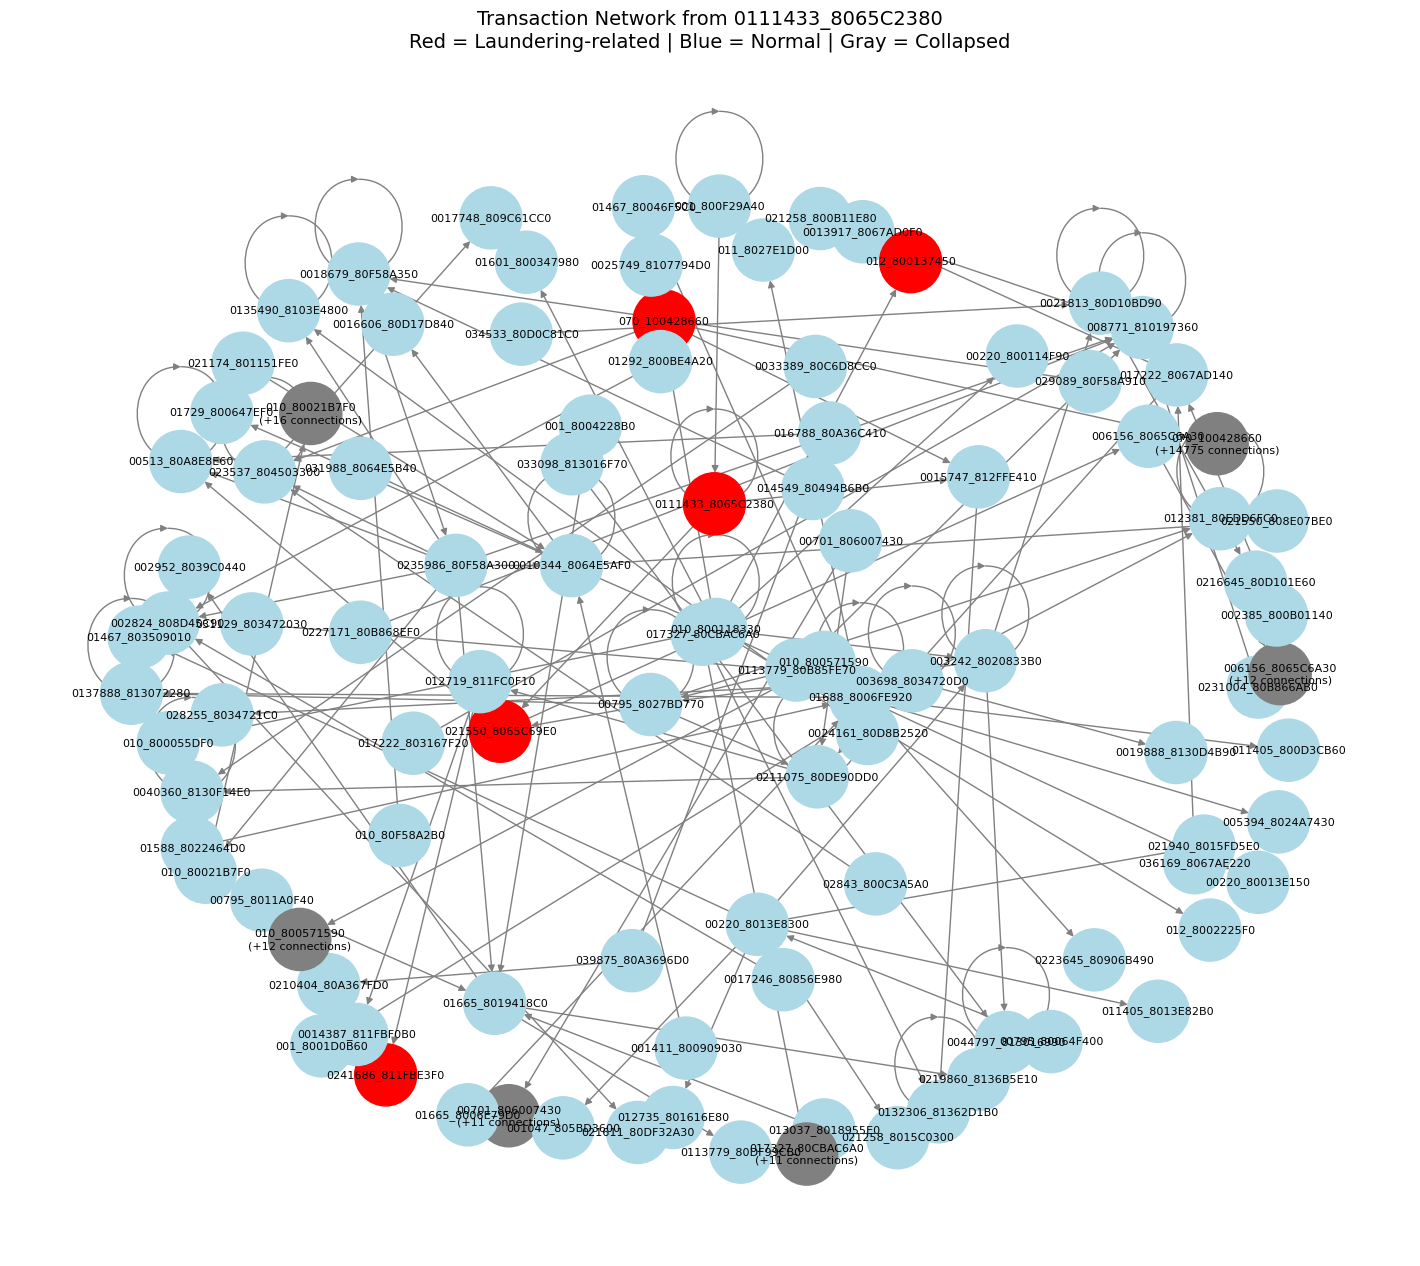

: 

In [ ]:
visualize_transaction_network(
    df,
    start_node="0111433_8065C2380",
    max_depth=4,
    collapse_threshold=10
)

In [ ]:
pattern_df = pd.DataFrame(pattern_dict['STACK'])
pattern_df.columns = columns

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from io import StringIO

# --- Paste your data here ---
data = """2022/09/02 12:36,0223,8000DD890,0040312,80F52D550,14153.46,Swiss Franc,14153.46,Swiss Franc,ACH,1
2022/09/03 19:52,0040312,80F52D550,0023370,80BEA98A0,11975.53,UK Pound,11975.53,UK Pound,ACH,1
2022/09/01 10:19,018617,8038D3520,024482,801C0F2B0,13712.96,Euro,13712.96,Euro,ACH,1
2022/09/03 05:06,024482,801C0F2B0,0214,80C1B9E20,333126.09,Mexican Peso,333126.09,Mexican Peso,ACH,1
2022/09/01 09:22,0040836,80F6B88B0,0016606,8064545E0,11800.69,US Dollar,11800.69,US Dollar,ACH,1
2022/09/03 08:27,0016606,8064545E0,002454,80662A070,12331.00,US Dollar,12331.00,US Dollar,ACH,1
2022/09/02 07:21,021749,8014BDC90,0214050,80537F610,317448.19,Rupee,317448.19,Rupee,ACH,1
2022/09/04 19:11,0214050,80537F610,0017554,806C8F2A0,349281.29,Ruble,349281.29,Ruble,ACH,1
2022/09/01 15:05,023842,80195DE20,002845,801E2BC20,277.59,US Dollar,277.59,US Dollar,ACH,1
2022/09/04 09:31,002845,801E2BC20,0220504,807E97240,230.27,UK Pound,230.27,UK Pound,ACH,1
2022/09/01 14:28,010,8009CF210,011318,8011AB110,11964.97,US Dollar,11964.97,US Dollar,ACH,1
2022/09/03 09:33,011318,8011AB110,028255,806C7CF80,11521.43,US Dollar,11521.43,US Dollar,ACH,1
2022/09/02 19:34,003229,803FF9220,0220271,81114D580,10295.53,US Dollar,10295.53,US Dollar,ACH,1
2022/09/04 04:56,0220271,81114D580,013145,809BD8BC0,9743.15,US Dollar,9743.15,US Dollar,ACH,1
2022/09/02 07:37,0115700,80B3E96E0,014099,801F8CCB0,17684.19,US Dollar,17684.19,US Dollar,ACH,1
2022/09/03 04:39,014099,801F8CCB0,024144,801C92FF0,14819.83,Euro,14819.83,Euro,ACH,1
2022/09/01 18:17,022806,807A61380,006179,802D53D80,16345.56,US Dollar,16345.56,US Dollar,ACH,1
2022/09/04 01:29,006179,802D53D80,0240229,80EE2B9B0,14199.39,Swiss Franc,14199.39,Swiss Franc,ACH,1
2022/09/01 08:40,0214,80B7347A0,00410,802D878C0,6702.62,Euro,6702.62,Euro,ACH,1
2022/09/03 01:44,00410,802D878C0,003229,8063F5290,7617.17,US Dollar,7617.17,US Dollar,ACH,1
2022/09/01 16:51,02591,80A1C7710,024850,80A09CF50,3724.19,Euro,3724.19,Euro,ACH,1
2022/09/02 12:47,024850,80A09CF50,023833,8067AD0A0,4646.02,US Dollar,4646.02,US Dollar,ACH,1"""

# data = pattern_dict['STACK']
# print(data)
# --- Parse into DataFrame ---
cols = [
    "timestamp", "sender_id", "sender_acct", "receiver_id", "receiver_acct",
    "amount", "currency", "amount2", "currency2", "method", "flag"
]

df = pd.read_csv(StringIO(data), header=None)
df.columns = cols

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["amount"] = df["amount"].astype(float)

df["From_Node"] = df["sender_id"].astype(str) + "_" + df["sender_acct"].astype(str)
df["To_Node"] = df["receiver_id"].astype(str) + "_" + df["receiver_acct"].astype(str)

entity_path = os.path.join(current_dir, "data", "IBM", "Hi-Small_accounts.csv")

entity_df = pd.read_csv(entity_path, dtype=str)

entity_df["bank_id"] = entity_df["Bank ID"].astype(str) + "_" + entity_df["Account Number"].astype(str)

# Merge sender entity
merged_df = df.merge(
    entity_df[['bank_id', 'Entity Name']],
    how='left',
    left_on='From_Node',
    right_on='bank_id'
).rename(columns={'Entity Name': 'sender_entity'}).drop('bank_id', axis=1)

# Merge receiver entity
merged_df = merged_df.merge(
    entity_df[['bank_id', 'Entity Name']],
    how='left',
    left_on='To_Node',
    right_on='bank_id'
).rename(columns={'Entity Name': 'receiver_entity'}).drop('bank_id', axis=1)


# Preview result
merged_df.head()



,timestamp,sender_id,sender_acct,receiver_id,receiver_acct,amount,currency,amount2,currency2,method,flag,From_Node,To_Node,sender_entity,receiver_entity
0,2022-09-02 12:36:00,223,8000DD890,40312,80F52D550,14153.46,Swiss Franc,14153.46,Swiss Franc,ACH,1,223_8000DD890,40312_80F52D550,Corporation #37872,Corporation #34867
1,2022-09-03 19:52:00,40312,80F52D550,23370,80BEA98A0,11975.53,UK Pound,11975.53,UK Pound,ACH,1,40312_80F52D550,23370_80BEA98A0,Corporation #34867,Sole Proprietorship #34405
2,2022-09-01 10:19:00,18617,8038D3520,24482,801C0F2B0,13712.96,Euro,13712.96,Euro,ACH,1,18617_8038D3520,24482_801C0F2B0,Corporation #13190,Partnership #30131
3,2022-09-03 05:06:00,24482,801C0F2B0,214,80C1B9E20,333126.09,Mexican Peso,333126.09,Mexican Peso,ACH,1,24482_801C0F2B0,214_80C1B9E20,Partnership #30131,Corporation #3948
4,2022-09-01 09:22:00,40836,80F6B88B0,16606,8064545E0,11800.69,US Dollar,11800.69,US Dollar,ACH,1,40836_80F6B88B0,16606_8064545E0,Partnership #37691,Corporation #8544


: 

In [ ]:
data2 = pattern_dict['STACK']

df2 = pd.DataFrame(data2, columns=cols)

df2

,timestamp,sender_id,sender_acct,receiver_id,receiver_acct,amount,currency,amount2,currency2,method,flag
0,2022/09/02 12:36,0223,8000DD890,0040312,80F52D550,14153.46,Swiss Franc,14153.46,Swiss Franc,ACH,1
1,2022/09/03 19:52,0040312,80F52D550,0023370,80BEA98A0,11975.53,UK Pound,11975.53,UK Pound,ACH,1
2,2022/09/01 10:19,018617,8038D3520,024482,801C0F2B0,13712.96,Euro,13712.96,Euro,ACH,1
3,2022/09/03 05:06,024482,801C0F2B0,0214,80C1B9E20,333126.09,Mexican Peso,333126.09,Mexican Peso,ACH,1
4,2022/09/01 09:22,0040836,80F6B88B0,0016606,8064545E0,11800.69,US Dollar,11800.69,US Dollar,ACH,1
5,2022/09/03 08:27,0016606,8064545E0,002454,80662A070,12331.00,US Dollar,12331.00,US Dollar,ACH,1
6,2022/09/02 07:21,021749,8014BDC90,0214050,80537F610,317448.19,Rupee,317448.19,Rupee,ACH,1
7,2022/09/04 19:11,0214050,80537F610,0017554,806C8F2A0,349281.29,Ruble,349281.29,Ruble,ACH,1
8,2022/09/01 15:05,023842,80195DE20,002845,801E2BC20,277.59,US Dollar,277.59,US Dollar,ACH,1
9,2022/09/04 09:31,002845,801E2BC20,0220504,807E97240,230.27,UK Pound,230.27,UK Pound,ACH,1


: 

In [ ]:
df

,timestamp,sender_id,sender_acct,receiver_id,receiver_acct,amount,currency,amount2,currency2,method,flag,From_Node,To_Node
0,2022-09-02 12:36:00,223,8000DD890,40312,80F52D550,14153.46,Swiss Franc,14153.46,Swiss Franc,ACH,1,223_8000DD890,40312_80F52D550
1,2022-09-03 19:52:00,40312,80F52D550,23370,80BEA98A0,11975.53,UK Pound,11975.53,UK Pound,ACH,1,40312_80F52D550,23370_80BEA98A0
2,2022-09-01 10:19:00,18617,8038D3520,24482,801C0F2B0,13712.96,Euro,13712.96,Euro,ACH,1,18617_8038D3520,24482_801C0F2B0
3,2022-09-03 05:06:00,24482,801C0F2B0,214,80C1B9E20,333126.09,Mexican Peso,333126.09,Mexican Peso,ACH,1,24482_801C0F2B0,214_80C1B9E20
4,2022-09-01 09:22:00,40836,80F6B88B0,16606,8064545E0,11800.69,US Dollar,11800.69,US Dollar,ACH,1,40836_80F6B88B0,16606_8064545E0
5,2022-09-03 08:27:00,16606,8064545E0,2454,80662A070,12331.00,US Dollar,12331.00,US Dollar,ACH,1,16606_8064545E0,2454_80662A070
6,2022-09-02 07:21:00,21749,8014BDC90,214050,80537F610,317448.19,Rupee,317448.19,Rupee,ACH,1,21749_8014BDC90,214050_80537F610
7,2022-09-04 19:11:00,214050,80537F610,17554,806C8F2A0,349281.29,Ruble,349281.29,Ruble,ACH,1,214050_80537F610,17554_806C8F2A0
8,2022-09-01 15:05:00,23842,80195DE20,2845,801E2BC20,277.59,US Dollar,277.59,US Dollar,ACH,1,23842_80195DE20,2845_801E2BC20
9,2022-09-04 09:31:00,2845,801E2BC20,220504,807E97240,230.27,UK Pound,230.27,UK Pound,ACH,1,2845_801E2BC20,220504_807E97240


: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os

# ----------------------------------------------------
# 1. Load tuple-list data from your dict
# ----------------------------------------------------
data = pattern_dict["STACK"]

cols = [
    "timestamp", "sender_id", "sender_acct", "receiver_id", "receiver_acct",
    "amount", "currency", "amount2", "currency2", "method", "flag"
]

df = pd.DataFrame(data, columns=cols)

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["amount"] = df["amount"].astype(float)

# Strip whitespace, convert to string
for col in ["sender_id", "sender_acct", "receiver_id", "receiver_acct"]:
    df[col] = df[col].astype(str).str.strip()

entity_path = os.path.join(current_dir, "data", "IBM", "Hi-Small_accounts.csv")
entity_df = pd.read_csv(entity_path, dtype=str)

for col in ["Bank ID", "Account Number"]:
    entity_df[col] = entity_df[col].astype(str).str.strip()

# --- Clean IDs: remove leading zeros ---
df["sender_id"]   = df["sender_id"].astype(str).str.lstrip("0")
df["receiver_id"] = df["receiver_id"].astype(str).str.lstrip("0")

entity_df["Bank ID"] = entity_df["Bank ID"].astype(str).str.lstrip("0")

df["From_Node"] = df["sender_id"] + "_" + df["sender_acct"]
df["To_Node"]   = df["receiver_id"] + "_" + df["receiver_acct"]

entity_df["bank_id"] = entity_df["Bank ID"] + "_" + entity_df["Account Number"]

# Debug print example keys
print("\nExample From_Node:", df["From_Node"].iloc[0])
print("Example To_Node:  ", df["To_Node"].iloc[0])
print("\nExample bank_id:", entity_df["bank_id"].iloc[0])

# ----------------------------------------------------
# 5. Merge sender entity
# ----------------------------------------------------
merged_df = df.merge(
    entity_df[['bank_id', 'Entity ID']],
    how='left',
    left_on='From_Node',
    right_on='bank_id'
).rename(columns={'Entity ID': 'sender_entity'}).drop(columns=['bank_id'])

# ----------------------------------------------------
# 6. Merge receiver entity
# ----------------------------------------------------
merged_df = merged_df.merge(
    entity_df[['bank_id', 'Entity ID']],
    how='left',
    left_on='To_Node',
    right_on='bank_id'
).rename(columns={'Entity ID': 'receiver_entity'}).drop(columns=['bank_id'])

# ----------------------------------------------------
# 7. Preview result
# ----------------------------------------------------
# print("\nMerged result preview:")
print(merged_df.head())



Example From_Node: 223_8000DD890
Example To_Node:   40312_80F52D550

Example bank_id: 331579_80B779D80
            timestamp sender_id sender_acct receiver_id receiver_acct  \
0 2022-09-02 12:36:00       223   8000DD890       40312     80F52D550   
1 2022-09-03 19:52:00     40312   80F52D550       23370     80BEA98A0   
2 2022-09-01 10:19:00     18617   8038D3520       24482     801C0F2B0   
3 2022-09-03 05:06:00     24482   801C0F2B0         214     80C1B9E20   
4 2022-09-01 09:22:00     40836   80F6B88B0       16606     8064545E0   

      amount      currency    amount2     currency2 method flag  \
0   14153.46   Swiss Franc   14153.46   Swiss Franc    ACH    1   
1   11975.53      UK Pound   11975.53      UK Pound    ACH    1   
2   13712.96          Euro   13712.96          Euro    ACH    1   
3  333126.09  Mexican Peso  333126.09  Mexican Peso    ACH    1   
4   11800.69     US Dollar   11800.69     US Dollar    ACH    1   

         From_Node          To_Node sender_entity rece

: 

In [ ]:
entity_df.head()


,Bank Name,Bank ID,Account Number,Entity ID,Entity Name,bank_id
0,Portugal Bank #4507,331579,80B779D80,80062E240,Sole Proprietorship #50438,331579_80B779D80
1,Canada Bank #27,210,809D86900,800C998A0,Corporation #33520,210_809D86900
2,UK Bank #33,21884,80812BE00,800C47F50,Partnership #35397,21884_80812BE00
3,Germany Bank #4815,32742,81047F300,80096F0B0,Corporation #48813,32742_81047F300
4,National Bank of Harrisburg,127390,80BD8CF00,800FB8760,Corporation #889,127390_80BD8CF00


: 

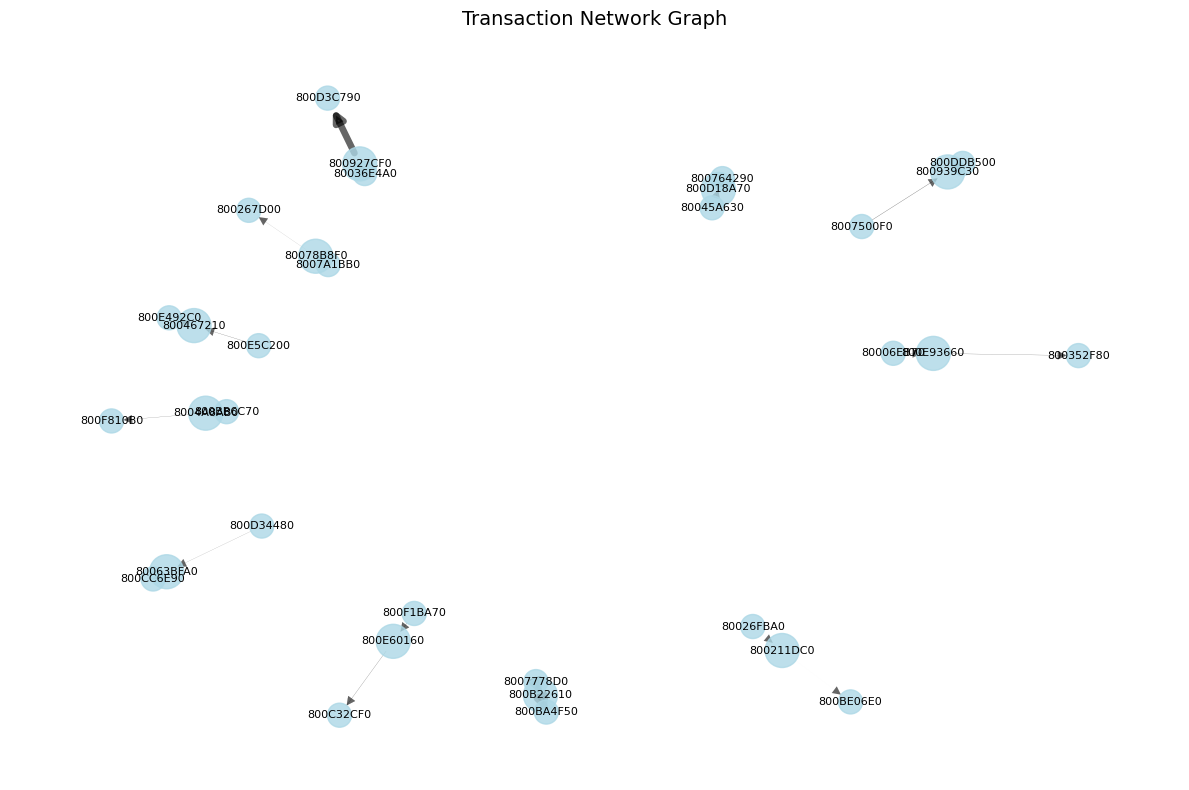

: 

In [ ]:
# --- Create directed graph ---
G = nx.DiGraph()

for _, row in merged_df.iterrows():
    sender = row["sender_entity"]
    receiver = row["receiver_entity"]
    amount = row["amount"]
    currency = row["currency"]
    
    # Add weighted edge
    if G.has_edge(sender, receiver):
        G[sender][receiver]["weight"] += amount
    else:
        G.add_edge(sender, receiver, weight=amount, currency=currency)

# --- Node sizes & edge widths ---
node_sizes = [G.degree(n) * 300 for n in G.nodes()]
edge_weights = [G[u][v]['weight'] / max(merged_df['amount']) * 5 for u, v in G.edges()]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Transaction Network Graph", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


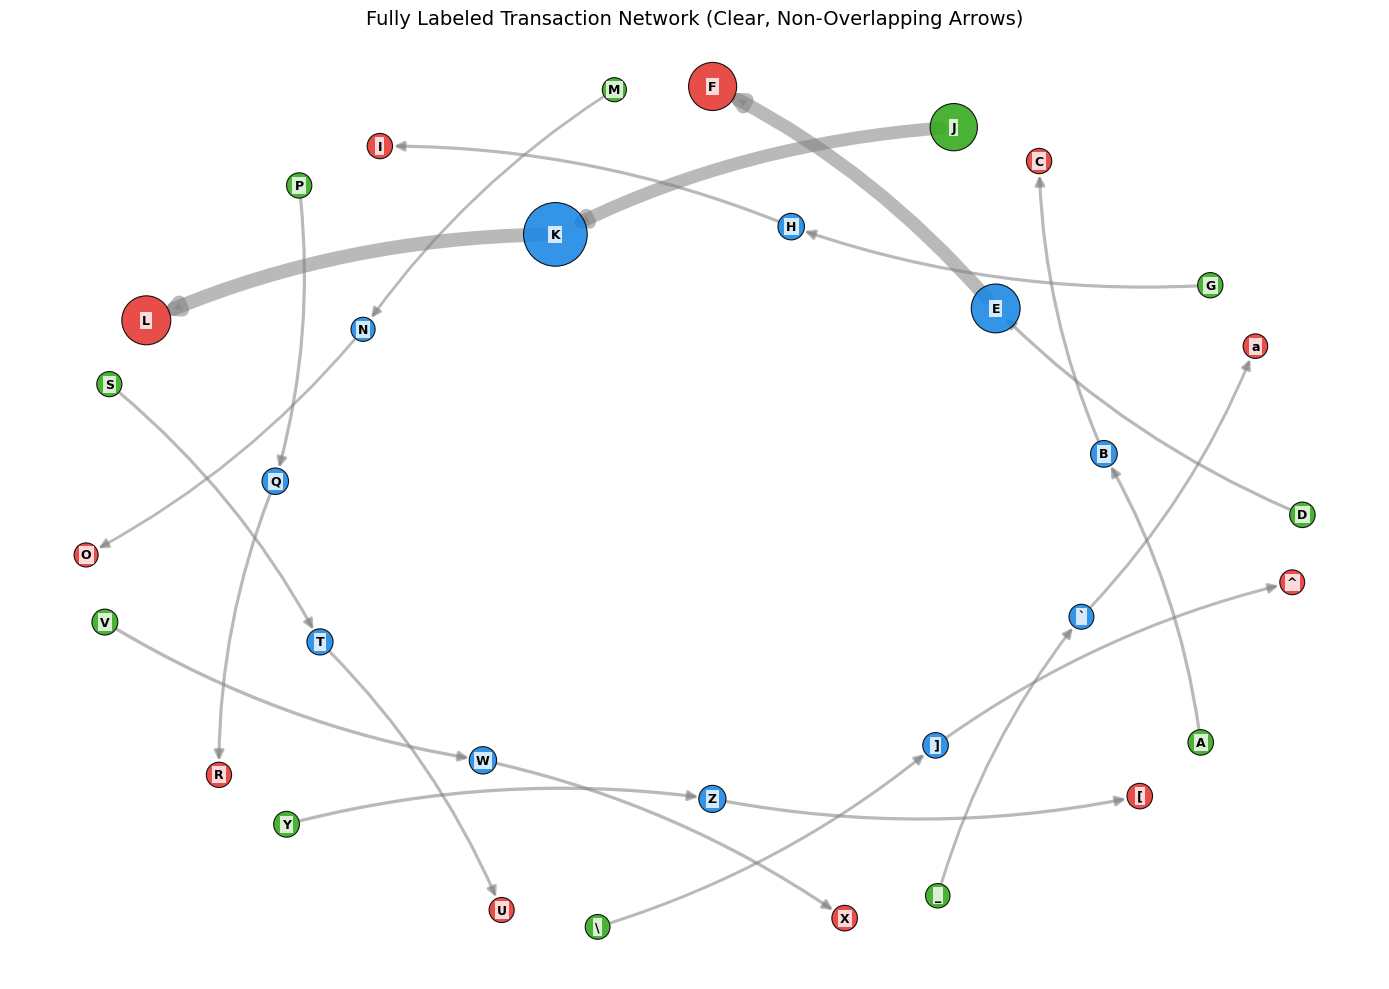

: 

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# --- Build directed graph ---
G = nx.DiGraph()
node_map = {}
next_label = 65  # ASCII 'A'

for _, row in df.iterrows():
    sender = row["From_Node"]
    receiver = row["To_Node"]
    amount = row["amount"]
    currency = row["currency"]

    # Assign short labels
    if sender not in node_map:
        node_map[sender] = chr(next_label)
        next_label += 1
    if receiver not in node_map:
        node_map[receiver] = chr(next_label)
        next_label += 1

    G.add_edge(
        node_map[sender],
        node_map[receiver],
        amount=amount,
        currency=currency
    )

# --- Compute node metrics ---
# Total transaction volume (in + out)
activity = {
    n: sum(d["amount"] for _, _, d in G.in_edges(n, data=True)) +
       sum(d["amount"] for _, _, d in G.out_edges(n, data=True))
    for n in G.nodes()
}

# --- Node & edge styling ---
max_amt = max(nx.get_edge_attributes(G, "amount").values())

# FIX: include data=True to unpack (u, v, d)
edge_weights = [2 + (d["amount"] / max_amt) * 8 for _, _, d in G.edges(data=True)]  # thicker = larger tx

node_sizes = [300 + (activity[n] / max(activity.values())) * 1800 for n in G.nodes()]

# Color nodes by role: source (only sends), sink (only receives), intermediary (both)
node_colors = []
for n in G.nodes():
    in_deg = G.in_degree(n)
    out_deg = G.out_degree(n)
    if in_deg == 0:
        node_colors.append("#36AA1E")  # green source
    elif out_deg == 0:
        node_colors.append("#E53935")  # red sink
    else:
        node_colors.append("#1E88E5")  # blue intermediary

# --- Layout ---
# Kamada–Kawai layout tends to minimize node & edge overlap nicely
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(14, 10))

# --- Draw nodes ---
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9,
    edgecolors="black",
    linewidths=0.8
)

# --- Draw edges with curvature & spacing ---
edges = list(G.edges(data=True))
for (u, v, d) in edges:
    width = 2 + (d["amount"] / max_amt) * 8
    
    # Curved edges for bidirectional relationships
    if G.has_edge(v, u):
        rad = 0.25 if hash((u, v)) % 2 == 0 else -0.25
    else:
        rad = 0.1 * np.sign(hash((u, v)) % 2 - 0.5)
    
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        width=width,
        edge_color="gray",
        alpha=0.55,
        arrows=True,
        arrowsize=14,
        connectionstyle=f"arc3,rad={rad}",
        min_source_margin=10,
        min_target_margin=10
    )

# --- Draw ALL labels with offset and white background ---
label_options = {
    "font_size": 9,
    "font_weight": "bold",
    "horizontalalignment": "center",
    "verticalalignment": "center",
    "bbox": dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.5)
}
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, **label_options)

# --- Final polish ---
plt.title("Fully Labeled Transaction Network (Clear, Non-Overlapping Arrows)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()



In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Ensure output directory exists
output_dir = os.path.join(current_dir, "entity_pattern_plots")
os.makedirs(output_dir, exist_ok=True)

# Load entity dataframe
entity_path = os.path.join(current_dir, "data", "IBM", "Hi-Small_accounts.csv")
entity_df = pd.read_csv(entity_path, dtype=str)
entity_df["Bank ID"] = entity_df["Bank ID"].astype(str).str.lstrip("0")

entity_df["bank_id"] = entity_df["Bank ID"].astype(str) + "_" + entity_df["Account Number"].astype(str)
print(entity_df.head())
cols = [
    "timestamp", "sender_id", "sender_acct", "receiver_id", "receiver_acct",
    "amount", "currency", "amount2", "currency2", "method", "flag"
]

for pattern_name, pattern_data in pattern_dict.items():
    # --- Parse into DataFrame ---
    df = pd.DataFrame(pattern_data)
    df.columns = cols

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["amount"] = df["amount"].astype(float)
    df["sender_id"]   = df["sender_id"].astype(str).str.lstrip("0")
    df["receiver_id"] = df["receiver_id"].astype(str).str.lstrip("0")

    df["From_Node"] = df["sender_id"].astype(str) + "_" + df["sender_acct"].astype(str)
    df["To_Node"] = df["receiver_id"].astype(str) + "_" + df["receiver_acct"].astype(str)

    # Merge sender entity
    merged_df = df.merge(
        entity_df[['bank_id', 'Entity ID']],
        how='left',
        left_on='From_Node',
        right_on='bank_id'
    ).rename(columns={'Entity ID': 'sender_entity'}).drop('bank_id', axis=1)

    # Merge receiver entity
    merged_df = merged_df.merge(
        entity_df[['bank_id', 'Entity ID']],
        how='left',
        left_on='To_Node',
        right_on='bank_id'
    ).rename(columns={'Entity ID': 'receiver_entity'}).drop('bank_id', axis=1)

    # --- Create directed graph ---
    G = nx.DiGraph()
    for _, row in merged_df.iterrows():
        sender = row["sender_entity"]
        receiver = row["receiver_entity"]
        amount = row["amount"]
        currency = row["currency"]

        if pd.isna(sender) or pd.isna(receiver):
            continue  # Skip if entity mapping is missing

        if G.has_edge(sender, receiver):
            G[sender][receiver]["weight"] += amount
        else:
            G.add_edge(sender, receiver, weight=amount, currency=currency)

    # --- Node sizes & edge widths ---
    node_sizes = [G.degree(n) * 300 for n in G.nodes()]
    max_amount = merged_df['amount'].max()
    edge_weights = [G[u][v]['weight'] / max_amount * 5 for u, v in G.edges()]

    # --- Plot graph ---
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f"Transaction Network Graph - {pattern_name}", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(output_dir, f"{pattern_name}.png")
    plt.savefig(plot_path, dpi=300)
    plt.close()

print(f"All plots saved in: {output_dir}")


                     Bank Name Bank ID Account Number  Entity ID  \
0          Portugal Bank #4507  331579      80B779D80  80062E240   
1              Canada Bank #27     210      809D86900  800C998A0   
2                  UK Bank #33   21884      80812BE00  800C47F50   
3           Germany Bank #4815   32742      81047F300  80096F0B0   
4  National Bank of Harrisburg  127390      80BD8CF00  800FB8760   

                  Entity Name           bank_id  
0  Sole Proprietorship #50438  331579_80B779D80  
1          Corporation #33520     210_809D86900  
2          Partnership #35397   21884_80812BE00  
3          Corporation #48813   32742_81047F300  
4            Corporation #889  127390_80BD8CF00  


C:\Users\lucsc\AppData\Local\Temp\ipykernel_2712\835388537.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
C:\Users\lucsc\AppData\Local\Temp\ipykernel_2712\835388537.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
C:\Users\lucsc\AppData\Local\Temp\ipykernel_2712\835388537.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
C:\Users\lucsc\AppData\Local\Temp\ipykernel_2712\835388537.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.d

All plots saved in: c:\Users\lucsc\Thesis\grad\grad\entity_pattern_plots


: 

: 